In [2]:
%matplotlib inline
import math, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, operator
from importlib import reload

In [3]:
import kmeans; reload(kmeans)
from kmeans import Kmeans

In [121]:
n_clusters=6
n_samples =2500

In [122]:
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
           for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

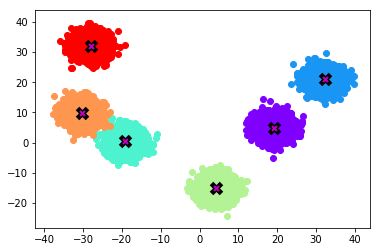

In [123]:
kmeans.plot_data(centroids, data, n_samples)

# Kmeans

In [124]:
k = Kmeans(data, n_clusters)

In [125]:
with tf.Session().as_default():
    %time new_centroids = k.run()

CPU times: user 292 ms, sys: 8 ms, total: 300 ms
Wall time: 283 ms


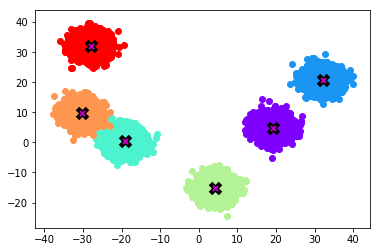

In [126]:
kmeans.plot_data(new_centroids, data, n_samples)

# Mean shift with LSH

In [127]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [128]:
def dist_b(a,b):
    return torch.sqrt((sub(a.unsqueeze(0),b.unsqueeze(1))**2).sum(2))

In [129]:
def sum_sqz(a,axis): return a.sum(axis).squeeze(axis)

In [130]:
import torch
import numpy as np
from torch_utils import * 

class PyTorchLSHash(object):
    
    def __init__(self, hash_size, input_dim):
        self.hash_size = hash_size
        self.uniform_planes = torch.rand(hash_size, input_dim)

    def index(self, input_points):
        planes = self.uniform_planes.t().cuda()
        projections = dot(input_points, planes)
        hashes = projections > 0
        self.hash_tables = dot(hashes.float(),torch.FloatTensor([2**exp for exp in range(self.hash_size,0,-1)]).unsqueeze(1).cuda())
        
    
    def query(self, slice, input_points, number_of_results=100):
        mask_size = len(input_points), 1
        mask = torch.zeros(mask_size).byte().cuda()
        
        for each in np.unique(self.hash_tables[slice].cpu().numpy()):
            new_mask = self.hash_tables.eq(int(each))
            mask += new_mask
        # randomly select number_of_results from existing mask
        m = torch.ones(mask_size) / mask.sum() * number_of_results
        mask = m.squeeze().cuda() * mask.float().cuda()
        mask = torch.bernoulli(mask).byte().unsqueeze(1)
            
        return torch.masked_select(input_points, mask.expand_as(input_points)).resize_(mask.sum(),input_points.size()[1])

In [131]:
def meanshift_lsh(data, bs=500):
    n = len(data)
    X = torch.FloatTensor(np.copy(data)).cuda()
    
    for it in range(5):
        pylsh = PyTorchLSHash(6, 2)
        pylsh.index(X)
        for i in range(0,n,bs):
            s = slice(i,min(n, i+bs))
            candidates = pylsh.query(s, X, bs)
            weight = gaussian(dist_b(candidates, X[s]), 2)
            num = sum_sqz(mul(weight, candidates), 1)
            X[s] = div(num, sum_sqz(weight, 1))
    return X

In [132]:
%time X=meanshift_lsh(data)

CPU times: user 392 ms, sys: 48 ms, total: 440 ms
Wall time: 441 ms


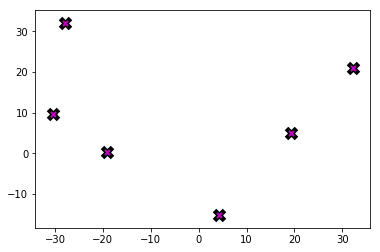

In [133]:
kmeans.plot_data(new_centroids, X.cpu().numpy(), n_samples)

# Meanshift with random draw

In [134]:
def meanshift_random(data, bs=500):
    n = len(data)
    X = torch.FloatTensor(np.copy(data)).cuda()
    
    for it in range(5):
        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            candidates = X[torch.randperm(len(X))[slice(0,bs)].long().cuda()]
            weight = gaussian(dist_b(candidates, X[s]), 2)
            num = sum_sqz(mul(weight, candidates), 1)
            X[s] = div(num, sum_sqz(weight, 1))
    return X

In [135]:
%time X=meanshift_random(data)

CPU times: user 296 ms, sys: 44 ms, total: 340 ms
Wall time: 341 ms


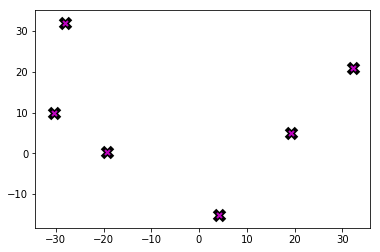

In [136]:
kmeans.plot_data(new_centroids, X.cpu().numpy(), n_samples)

In [ ]:
# 